In [16]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

In [7]:
from torch.utils import data
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

  
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  else:
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  
  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)
  
  def __len__(self):
    return len(self.dl)

In [8]:
# # extend nn.Module for further functionality
class MnistModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_classes):
      super().__init__()
      self.linear1 = nn.Linear(input_size, hidden_size)
      self.linear2 = nn.Linear(hidden_size, output_classes)
        
    def forward(self, xb):
      xb = xb.view(xb.size(0), -1)
      out = self.linear1(xb)
      out = F.relu(out)
      out = self.linear2(out)
      return out
    
    def training_step(self, batch):
      images, labels = batch 
      out = self(images)                  # Generate predictions
      loss = F.cross_entropy(out, labels) # Calculate loss(F.cross_entropy has softmax internally)
      return loss
    
    def validation_step(self, batch):
      images, labels = batch 
      out = self(images)                    # Generate predictions
      loss = F.cross_entropy(out, labels)   # Calculate loss(F.cross_entropy has softmax internally)
      acc = accuracy(out, labels)           # Calculate accuracy
      return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
      batch_losses = [x['val_loss'] for x in outputs]
      epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
      batch_accs = [x['val_acc'] for x in outputs]
      epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
      return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
      print("Epoch [{}], last_lr: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
          epoch, result['lr'][-1], result['val_loss'], result['val_acc']))


def fit_one_cycle(epochs, max_lr, model, train_loader, 
                  val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  history = [] # for recording epoch result

  optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
  schedule = torch.optim.lr_scheduler.OneCycleLR(
      optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
  for epoch in range(epochs):
      
      model.train()
      train_loss = []
      lr = []
      # Training
      for batch in train_loader:
          loss = model.training_step(batch)
          train_loss.append(loss)
          loss.backward()

          # gradient clipping
          if grad_clip:
            nn.utils.clip_grad_value_(model.parameters(), grad_clip)


          optimizer.step()
          optimizer.zero_grad()

          lr.append(get_lr(optimizer))
          schedule.step()
      
      # Validation
      result = evaluate(model, val_loader)
      result['train_loss'] = torch.stack(train_loss).mean().item()
      result['lr']  = lr
      model.epoch_end(epoch, result)
      history.append(result)

  return history

# plot
def accuracy_vs_epoch(history):
  accuracies = [result['val_acc'] for result in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs')


def losses_vs_epoch(history):
  train_losses = [result.get('train_loss') for result in history]
  val_losses = [result['val_loss'] for result in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-ro')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs Epoch')


def plot_lr(history):
  learning_rate = np.concatenate([result.get('lr', []) for result in history])
  plt.plot(learning_rate)
  plt.xlabel('Batch')
  plt.ylabel('Learning Rate')
  plt.title('Learning Rate vs Batch')

In [9]:
# # data preparation
dataset = MNIST(
    root='./data', download=True, transform=transforms.ToTensor())

for_train, for_validation = random_split(dataset, [50000, 10000])
# print(len(for_train), len(for_test))
batch_size = 128
train_loader = DataLoader(
    for_train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(
    for_validation, batch_size, shuffle=True, num_workers=2, pin_memory=True)
in_size = 28*28
out_classes = 10

# # define evaluation fuction
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']
    
# # inspect accuracy
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [10]:
# loop data through model
device = get_default_device()
original_model = MnistModel(input_size=in_size, hidden_size=64, output_classes=out_classes)
model = to_device(original_model, device)
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(val_loader, device)
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 0.0001
opt_func = torch.optim.Adam

In [11]:
# start to train here!!!
%%time
history = [evaluate(model, valid_dl)]
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                         weight_decay, grad_clip, opt_func)

Epoch [0], last_lr: 0.0028, val_loss: 0.2992, val_acc: 0.9139
Epoch [1], last_lr: 0.0076, val_loss: 0.1795, val_acc: 0.9466
Epoch [2], last_lr: 0.0100, val_loss: 0.1591, val_acc: 0.9518
Epoch [3], last_lr: 0.0095, val_loss: 0.1427, val_acc: 0.9585
Epoch [4], last_lr: 0.0081, val_loss: 0.1542, val_acc: 0.9527
Epoch [5], last_lr: 0.0061, val_loss: 0.1407, val_acc: 0.9577
Epoch [6], last_lr: 0.0039, val_loss: 0.0981, val_acc: 0.9702
Epoch [7], last_lr: 0.0019, val_loss: 0.0900, val_acc: 0.9732
Epoch [8], last_lr: 0.0005, val_loss: 0.0790, val_acc: 0.9767
Epoch [9], last_lr: 0.0000, val_loss: 0.0792, val_acc: 0.9767
CPU times: user 21 s, sys: 2.73 s, total: 23.7 s
Wall time: 1min 19s


In [12]:
# plot
def accuracy_vs_epoch(history):
  accuracies = [result['val_acc'] for result in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs')


def losses_vs_epoch(history):
  train_losses = [result.get('train_loss') for result in history]
  val_losses = [result['val_loss'] for result in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-ro')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs Epoch')


def plot_lr(history):
  learning_rate = np.concatenate([result.get('lr', []) for result in history])
  plt.plot(learning_rate)
  plt.xlabel('Batch')
  plt.ylabel('Learning Rate')
  plt.title('Learning Rate vs Batch')

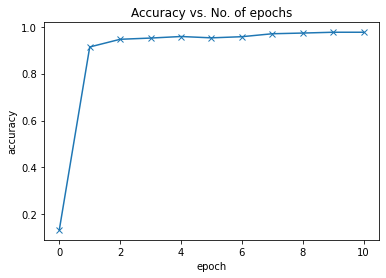

In [13]:
accuracy_vs_epoch(history)

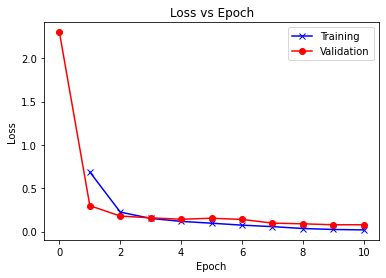

In [14]:
losses_vs_epoch(history)

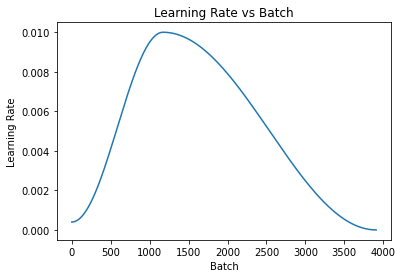

In [17]:
plot_lr(history)

In [18]:
torch.save(model.state_dict(), 'MNIST-ReLU.pth')